In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [16]:
df_leads = pd.read_csv('../data/terraz/processed_leads/leads.csv').\
    drop('Criado', axis=1)
df_leads.shape

/tmp/ipykernel_9618/1301142846.py:1: DtypeWarning: Columns (47,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_leads = pd.read_csv('../data/terraz/processed_leads/leads.csv').\


(171166, 62)

In [17]:
def treat_etapa(string):
    if string in ['Lead Duplicado', 'Lead Visita Duplicado', 'Lead Frio']:
        return 'Lead'
    elif 'BOT' in string:
        return 'Bot'
    else:
        return string

def treat_fonte(string):
    if string in ['Imovelweb', 'Grupo Zap', 'OLX', 'Mercado Livre', 'Facebook', 'Instagram', 'Google']:
        return 'Webpage'
    else:
        return 'Brognoli_init'

def treat_created(string):
    if 'Bot' in string or 'Brognoli' in string:
        return 'Bot'
    else:
        return 'Humano'

def treat_categ(string):
    if string in ['Apartamento', 'Kitnet', 'Casa', 'Cobertura', 'Loft', 'Terreno Residencial', 'Sobrado Residencial', 'Casa em condomónio', 'Chalé', 'Sítio']:
        return 'Moradia'
    elif string == 'Missing':
        return string
    else:
        return 'Comercial'
    

In [18]:
df_leads['Etapa'] = df_leads['Etapa'].apply(lambda x: treat_etapa(x))
df_leads['Fonte'] = df_leads['Fonte'].apply(lambda x: treat_fonte(x))
df_leads['Criado por'] = df_leads['Criado por'].apply(lambda x: treat_created(x))
df_leads['Categoria Imovel'] = df_leads['Categoria Imovel'].apply(lambda x: treat_categ(x))
df_leads['Categoria Imovel'].unique()

array(['Moradia', 'Missing', 'Comercial'], dtype=object)

In [19]:
df_etapa = pd.get_dummies(df_leads['Etapa'], dtype='int')
df_fonte = pd.get_dummies(df_leads['Fonte'], dtype='int')
# df_resp = pd.get_dummies(df_leads['Responsável'], dtype='int')
df_criado = pd.get_dummies(df_leads['Criado por'], dtype='int')
df_canal = pd.get_dummies(df_leads['Canal'], dtype='int')
df_imob = pd.get_dummies(df_leads['Imobiliária: Geradora do lead'], dtype='int')
df_categ = pd.get_dummies(df_leads['Categoria Imovel'], dtype='int')
df_season = pd.get_dummies(df_leads['season'], dtype='int')
usable_cols = ['Email de trabalho',  'CPF do locatário', 'Etapa', 'criado_dias', 'dia_da_semana',
               'Fonte', 'Responsável', 'Criado por', 'Total', 'Canal', 'dia', 'mes', 'ano',
               'Imobiliária: Geradora do lead', 'Categoria Imovel', 'visited', 'desistiu', 'cep3',
               'season', 'hora_visita', 'minuto_visita']
df_model = pd.concat([df_leads[usable_cols], df_etapa, df_fonte, df_criado, df_canal, df_imob, df_categ, df_season], axis=1)
df_leads = pd.concat([df_leads, df_etapa, df_fonte, df_criado, df_canal, df_imob, df_categ, df_season], axis=1)
# df_model['cep3'] = df_model['cep3'].astype('int', errors='ignore')

In [20]:
encoded = ['Etapa', 'Fonte', 'Responsável', 'Criado por', 'Canal', 'Imobiliária: Geradora do lead', 'Categoria Imovel', 'season', 'cep3']

In [21]:
df_model.drop(encoded, axis=1, inplace=True)

In [22]:
df_model.head()

,Email de trabalho,CPF do locatário,criado_dias,dia_da_semana,Total,dia,mes,ano,visited,desistiu,...,Woliver,Brognoli,Terraz,Comercial,Missing,Moradia,Autumn,Spring,Summer,Winter
0,NaN,450.439.098-11,638,4,1500.0,31,12,2021,0,1,...,0,0,1,0,0,1,0,0,0,1
1,ferrari.fernandal@gmail.com,NaN,638,4,1900.0,31,12,2021,1,1,...,0,1,0,0,1,0,0,0,0,1
2,ferrari.fernandal@gmail.com,NaN,638,4,1900.0,31,12,2021,1,0,...,0,1,0,0,1,0,0,0,0,1
3,rah.rc26@gmail.com,023.674.790-89,638,4,1600.0,31,12,2021,0,1,...,0,0,1,0,0,1,0,0,0,1
4,vivianepacheco0109@gmail.com,090.572.379-11,638,4,1450.0,31,12,2021,0,1,...,0,1,0,0,0,1,0,0,0,1


In [23]:
pca = PCA()
pca.fit(df_model.drop(['Email de trabalho',  'CPF do locatário'], axis=1))

PCA()

In [24]:
len(np.round(pca.explained_variance_ratio_, 2))

34

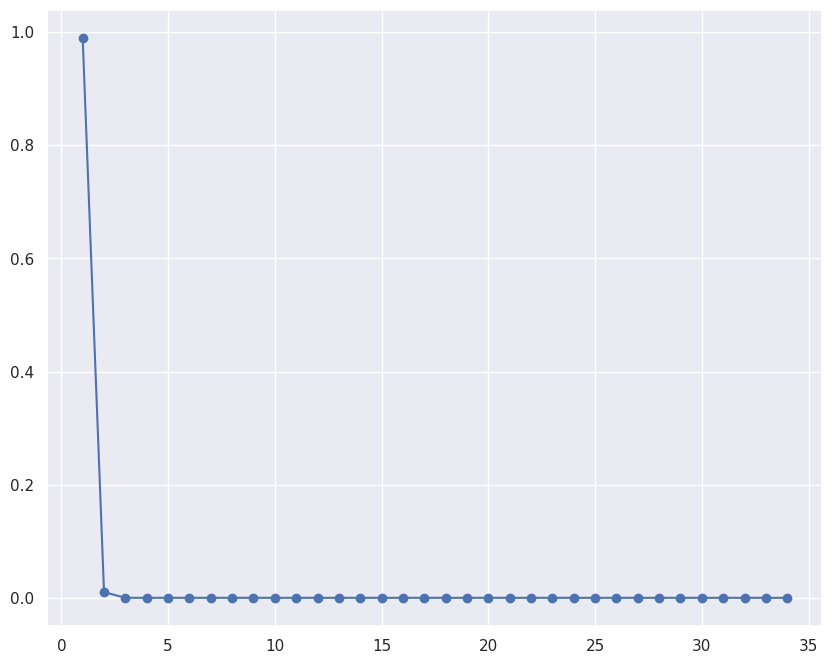

In [25]:
plt.figure(figsize=(10,8))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')

In [26]:
wcss = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_model.drop(['Email de trabalho',  'CPF do locatário'], axis=1))
    wcss.append(kmeans.inertia_)

/home/danielviegas/PycharmProjects/supermind_ingestor/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/danielviegas/PycharmProjects/supermind_ingestor/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/danielviegas/PycharmProjects/supermind_ingestor/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/danielviegas/PycharmProjects/super

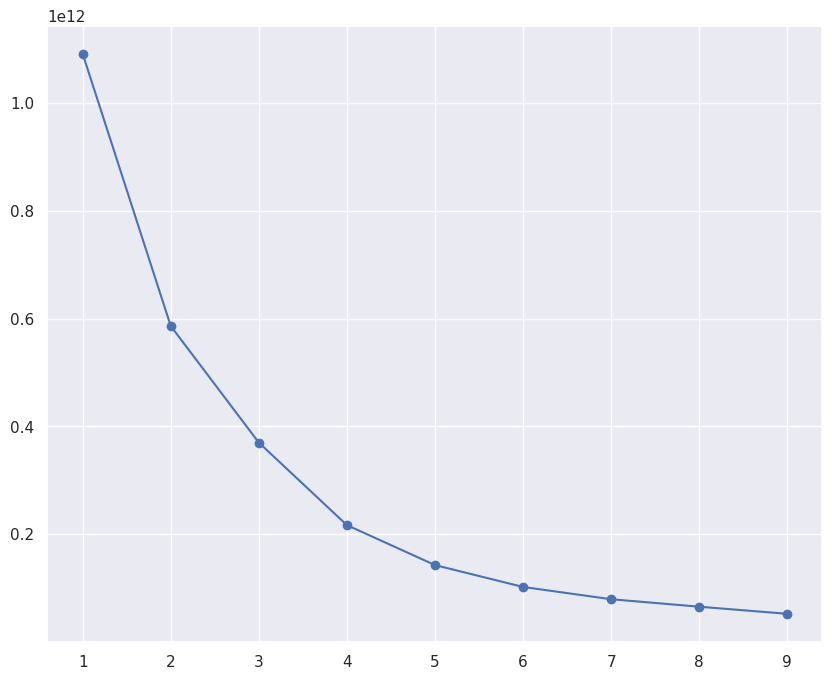

In [27]:
plt.figure(figsize=(10,8))
plt.plot(range(1,10), wcss, marker='o')

In [28]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(df_model.drop(['Email de trabalho',  'CPF do locatário'], axis=1))

/home/danielviegas/PycharmProjects/supermind_ingestor/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=42)

In [29]:
df_leads['Cluster'] = kmeans.labels_

In [30]:
# df_leads.groupby('Cluster').mean()

In [31]:
df_leads.to_csv('terraz_leads_marcados.csv', index=False)